In [1]:
# ==============================================================
# Imports & Seed
# ==============================================================
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
BASE_DIR = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2"

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [5]:
full_dataset = torchvision.datasets.ImageFolder(BASE_DIR)

print("Classes:", full_dataset.classes)
print("Number of classes:", len(full_dataset.classes))
print("Total images:", len(full_dataset))

Classes: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Number of classes: 8
Total images: 8000


In [6]:
indices = np.arange(len(full_dataset))
targets = np.array(full_dataset.targets)

train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    stratify=targets,
    random_state=seed
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    stratify=targets[temp_idx],
    random_state=seed
)

train_dataset = Subset(
    torchvision.datasets.ImageFolder(BASE_DIR, transform=train_transforms),
    train_idx
)

val_dataset = Subset(
    torchvision.datasets.ImageFolder(BASE_DIR, transform=eval_transforms),
    val_idx
)

test_dataset = Subset(
    torchvision.datasets.ImageFolder(BASE_DIR, transform=eval_transforms),
    test_idx
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Train: 5600 | Val: 1200 | Test: 1200


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [9]:
def get_model(model_name, num_classes):
    if model_name == "resnet50":
        model = torchvision.models.resnet50(weights="IMAGENET1K_V1")
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet34":
        model = torchvision.models.resnet34(weights="IMAGENET1K_V1")
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "densenet121":
        model = torchvision.models.densenet121(weights="IMAGENET1K_V1")
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "densenet169":
        model = torchvision.models.densenet169(weights="IMAGENET1K_V1")
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "densenet201":
        model = torchvision.models.densenet201(weights="IMAGENET1K_V1")
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "vgg16":
        model = torchvision.models.vgg16(weights="IMAGENET1K_V1")
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(
            model.classifier[6].in_features, num_classes
        )

    elif model_name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(weights="IMAGENET1K_V1")
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[1] = nn.Linear(
            model.classifier[1].in_features, num_classes
        )

    else:
        raise ValueError("Invalid model name")

    return model


In [10]:
MODEL_NAME = "efficientnet_b0"  
# options:
# "resnet34", "resnet50"
# "densenet121", "densenet169", "densenet201"
# "vgg16"
# "efficientnet_b0"

num_classes = len(full_dataset.classes)
model = get_model(MODEL_NAME, num_classes).to(device)

print(f"Model loaded: {MODEL_NAME}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s] 


Model loaded: efficientnet_b0


In [11]:
targets_train = targets[train_idx]
class_counts = np.bincount(targets_train)

class_weights = torch.tensor(
    1.0 / class_counts,
    dtype=torch.float
).to(device)

print("Class weights:", class_weights)

Class weights: tensor([0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
       device='cuda:0')


In [12]:
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.1
)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)


In [13]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10
):
    best_val_loss = float("inf")
    history = []

    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        train_loss = 0
        train_correct = 0

        for x, y in tqdm(train_loader, leave=False):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        # -------- VALIDATION --------
        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Acc: {train_acc*100:.2f}% | "
            f"Val Acc: {val_acc*100:.2f}%"
        )

        # -------- SAVE BEST MODEL --------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

        history.append((train_acc, val_acc))

    return history


In [14]:
EPOCHS = 15

history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=EPOCHS
)


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [1/15] | Train Acc: 63.61% | Val Acc: 80.83%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [2/15] | Train Acc: 77.84% | Val Acc: 82.17%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [3/15] | Train Acc: 79.36% | Val Acc: 82.92%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [4/15] | Train Acc: 80.09% | Val Acc: 83.42%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [5/15] | Train Acc: 80.50% | Val Acc: 84.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [6/15] | Train Acc: 81.39% | Val Acc: 84.58%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [7/15] | Train Acc: 80.95% | Val Acc: 84.67%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [8/15] | Train Acc: 81.55% | Val Acc: 84.08%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [9/15] | Train Acc: 83.57% | Val Acc: 85.42%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [10/15] | Train Acc: 83.02% | Val Acc: 84.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [11/15] | Train Acc: 83.27% | Val Acc: 83.67%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [12/15] | Train Acc: 82.91% | Val Acc: 84.08%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [13/15] | Train Acc: 83.52% | Val Acc: 84.67%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [14/15] | Train Acc: 84.16% | Val Acc: 85.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [15/15] | Train Acc: 84.02% | Val Acc: 83.75%


In [15]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

print("Best model loaded for testing")


Best model loaded for testing


In [16]:
test_preds = []
test_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        test_preds.extend(preds)
        test_targets.extend(y.numpy())


In [17]:
print("📊 TEST PERFORMANCE\n")

print("Accuracy  :", accuracy_score(test_targets, test_preds) * 100)
print("Precision :", precision_score(test_targets, test_preds, average="macro") * 100)
print("Recall    :", recall_score(test_targets, test_preds, average="macro") * 100)
print("F1 Score  :", f1_score(test_targets, test_preds, average="macro") * 100)


📊 TEST PERFORMANCE

Accuracy  : 85.33333333333334
Precision : 85.3291361858965
Recall    : 85.33333333333333
F1 Score  : 85.28909002694762


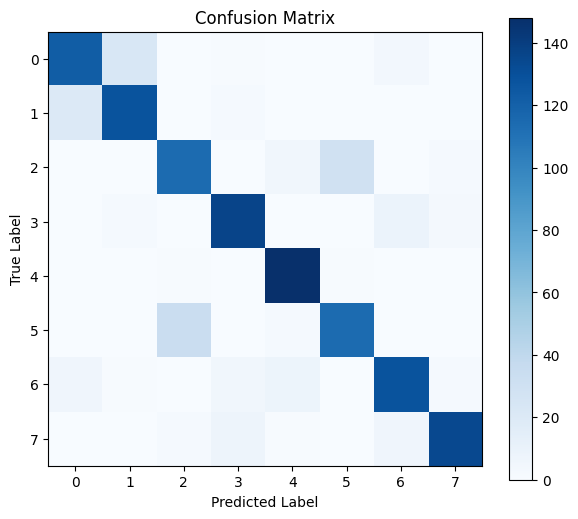

In [18]:
cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


In [19]:
model_names = [
    "densenet121",
    "densenet169",
    "densenet201",
    "vgg16",
    "efficientnet_b0",
    "resnet34",
    "resnet50"
]


In [20]:
def train_and_evaluate(model_name, epochs=15):
    print(f"\n==============================")
    print(f"Training model: {model_name}")
    print(f"==============================")

    # -------- Load Model --------
    model = get_model(model_name, num_classes).to(device)

    # -------- Loss & Optimizer --------
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1
    )

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-4,
        weight_decay=1e-4
    )

    # -------- Train --------
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_correct = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_correct += (outputs.argmax(1) == y).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        # -------- Validation --------
        model.eval()
        val_correct = 0
        val_loss = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Acc: {train_acc*100:.2f}% | "
            f"Val Acc: {val_acc*100:.2f}%"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")

    # -------- Test --------
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()

    test_preds, test_targets = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(1).cpu().numpy()

            test_preds.extend(preds)
            test_targets.extend(y.numpy())

    acc = accuracy_score(test_targets, test_preds)
    prec = precision_score(test_targets, test_preds, average="macro")
    rec = recall_score(test_targets, test_preds, average="macro")
    f1 = f1_score(test_targets, test_preds, average="macro")

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


In [ ]:
results = []

for name in model_names:
    result = train_and_evaluate(name, epochs=15)
    results.append(result)



Training model: densenet121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s] 


Epoch [1/15] | Train Acc: 59.25% | Val Acc: 79.92%
Epoch [2/15] | Train Acc: 77.50% | Val Acc: 83.08%
Epoch [3/15] | Train Acc: 79.66% | Val Acc: 85.33%
Epoch [4/15] | Train Acc: 81.68% | Val Acc: 85.17%
Epoch [5/15] | Train Acc: 82.77% | Val Acc: 85.67%
Epoch [6/15] | Train Acc: 84.05% | Val Acc: 86.08%
Epoch [7/15] | Train Acc: 83.86% | Val Acc: 85.50%
Epoch [8/15] | Train Acc: 84.45% | Val Acc: 85.92%
Epoch [9/15] | Train Acc: 84.57% | Val Acc: 85.67%
Epoch [10/15] | Train Acc: 84.68% | Val Acc: 86.75%
Epoch [11/15] | Train Acc: 85.86% | Val Acc: 85.83%
Epoch [12/15] | Train Acc: 85.20% | Val Acc: 86.08%
Epoch [13/15] | Train Acc: 85.59% | Val Acc: 86.33%
Epoch [14/15] | Train Acc: 85.30% | Val Acc: 87.25%
Epoch [15/15] | Train Acc: 85.52% | Val Acc: 87.92%

Training model: densenet169
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 164MB/s] 


Epoch [1/15] | Train Acc: 63.25% | Val Acc: 78.58%
Epoch [2/15] | Train Acc: 79.48% | Val Acc: 83.67%
Epoch [3/15] | Train Acc: 82.18% | Val Acc: 84.17%
Epoch [4/15] | Train Acc: 83.62% | Val Acc: 85.58%
Epoch [5/15] | Train Acc: 84.16% | Val Acc: 86.00%
Epoch [6/15] | Train Acc: 84.84% | Val Acc: 85.83%
Epoch [7/15] | Train Acc: 85.12% | Val Acc: 86.08%
Epoch [8/15] | Train Acc: 85.52% | Val Acc: 85.67%
Epoch [9/15] | Train Acc: 85.84% | Val Acc: 87.33%
Epoch [10/15] | Train Acc: 86.25% | Val Acc: 86.75%
Epoch [11/15] | Train Acc: 86.66% | Val Acc: 86.92%
Epoch [12/15] | Train Acc: 86.95% | Val Acc: 88.42%
Epoch [13/15] | Train Acc: 87.12% | Val Acc: 87.50%
Epoch [14/15] | Train Acc: 86.55% | Val Acc: 87.67%
Epoch [15/15] | Train Acc: 86.91% | Val Acc: 88.08%

Training model: densenet201
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 170MB/s] 


Epoch [1/15] | Train Acc: 65.71% | Val Acc: 79.92%
Epoch [2/15] | Train Acc: 81.32% | Val Acc: 84.83%
Epoch [3/15] | Train Acc: 82.07% | Val Acc: 85.08%
Epoch [4/15] | Train Acc: 83.57% | Val Acc: 85.75%
Epoch [5/15] | Train Acc: 84.73% | Val Acc: 85.83%
Epoch [6/15] | Train Acc: 85.09% | Val Acc: 87.25%
Epoch [7/15] | Train Acc: 86.02% | Val Acc: 87.17%
Epoch [8/15] | Train Acc: 86.20% | Val Acc: 86.17%
Epoch [9/15] | Train Acc: 86.62% | Val Acc: 86.08%
Epoch [10/15] | Train Acc: 86.45% | Val Acc: 87.33%
Epoch [11/15] | Train Acc: 87.23% | Val Acc: 86.67%
Epoch [12/15] | Train Acc: 87.52% | Val Acc: 86.83%
Epoch [13/15] | Train Acc: 87.50% | Val Acc: 87.00%
Epoch [14/15] | Train Acc: 87.55% | Val Acc: 87.92%
Epoch [15/15] | Train Acc: 88.75% | Val Acc: 87.08%

Training model: vgg16
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 179MB/s]  


Epoch [1/15] | Train Acc: 71.34% | Val Acc: 82.17%
Epoch [2/15] | Train Acc: 79.62% | Val Acc: 76.42%
Epoch [3/15] | Train Acc: 82.16% | Val Acc: 80.33%
Epoch [4/15] | Train Acc: 83.27% | Val Acc: 83.92%
Epoch [5/15] | Train Acc: 84.95% | Val Acc: 84.00%
Epoch [6/15] | Train Acc: 86.09% | Val Acc: 84.92%
Epoch [7/15] | Train Acc: 87.07% | Val Acc: 82.83%
Epoch [8/15] | Train Acc: 86.88% | Val Acc: 84.75%
Epoch [9/15] | Train Acc: 88.59% | Val Acc: 83.58%
Epoch [10/15] | Train Acc: 88.46% | Val Acc: 86.00%
Epoch [11/15] | Train Acc: 89.91% | Val Acc: 83.42%
Epoch [12/15] | Train Acc: 89.55% | Val Acc: 84.58%
Epoch [13/15] | Train Acc: 90.00% | Val Acc: 85.00%
Epoch [14/15] | Train Acc: 90.86% | Val Acc: 85.25%
Epoch [15/15] | Train Acc: 91.09% | Val Acc: 85.50%

Training model: efficientnet_b0
Epoch [1/15] | Train Acc: 64.23% | Val Acc: 80.42%
Epoch [2/15] | Train Acc: 77.68% | Val Acc: 83.83%
Epoch [3/15] | Train Acc: 79.05% | Val Acc: 83.08%
Epoch [4/15] | Train Acc: 80.66% | Val Acc:

100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


KeyboardInterrupt: 